In [1]:
# --- Imports and Setup ---
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


# --- 1. Configuration ---
STOCK_TICKER = 'HINDUNILVR.NS'
START_DATE = '2015-01-01'
END_DATE = '2025-07-20'

# --- 2. Data Collection ---
print(f"Fetching data for {STOCK_TICKER}...")
df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
if df.empty:
    raise ValueError("Data fetch failed. Check ticker or internet connection.")

df_close = df[['Close']].copy()
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close.asfreq('D')
df_close.ffill(inplace=True)
df_close.bfill(inplace=True)

Fetching data for HINDUNILVR.NS...


[*********************100%***********************]  1 of 1 completed


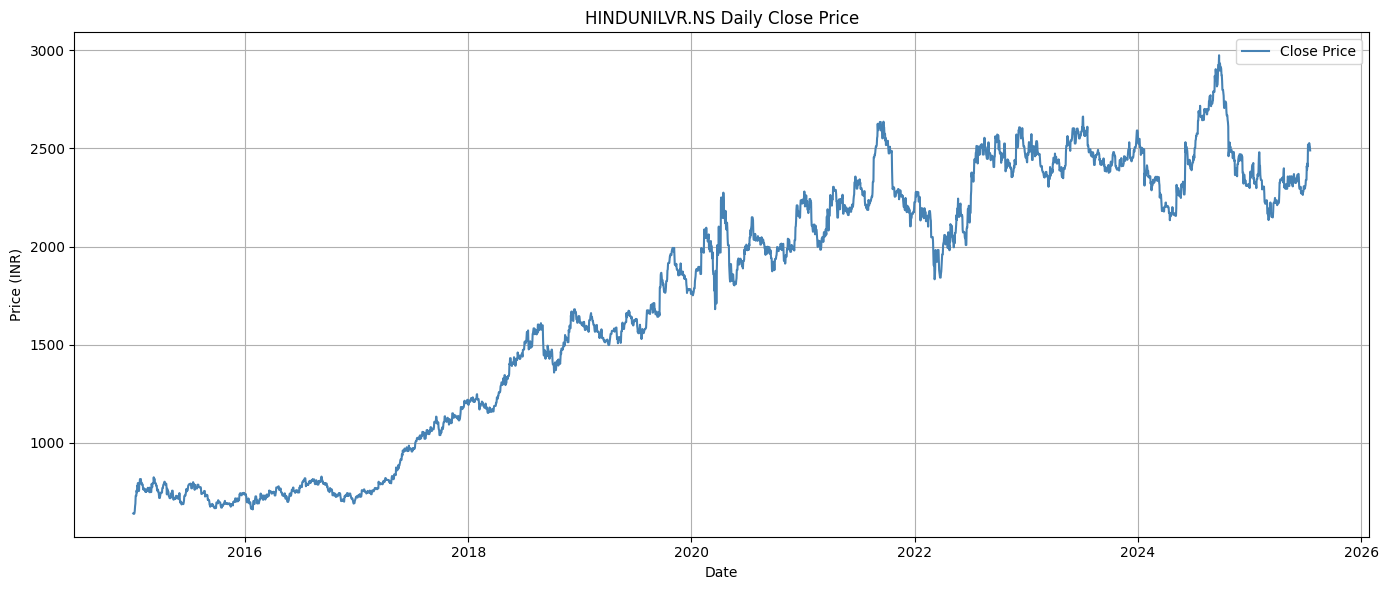

In [2]:
# --- 3. EDA: Visuals & Decomposition ---
plt.figure(figsize=(14, 6))
plt.plot(df_close['Close'], label='Close Price', color='steelblue')
plt.title(f'{STOCK_TICKER} Daily Close Price')
plt.xlabel('Date'); plt.ylabel('Price (INR)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0112
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0022
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0021
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0018
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0019
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0017
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0017
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0016
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0017
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0015
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0015
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0015
Epoch 13/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0013
Epoch 14/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0014
Epoch 15/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0012
Epo

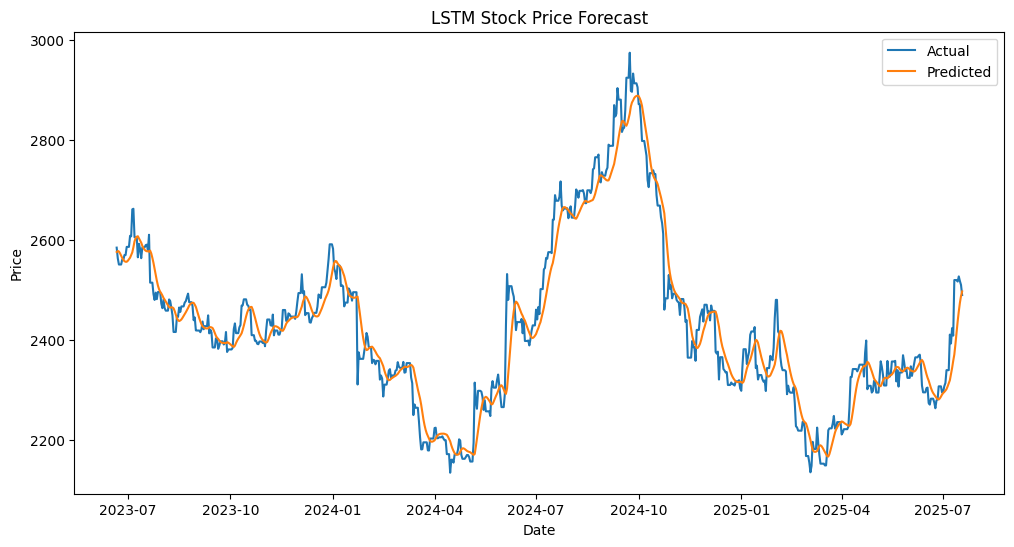

Root Mean Squared Error (RMSE): 42.11


In [3]:

# -------------------------------------------
# 3. 📉 Normalize the Data
# -------------------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_close)

# -------------------------------------------
# 4. 🔁 Create Sequences
# -------------------------------------------
# LSTM needs sequence of past values to predict the next one
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 60  # use past 60 days
X, y = create_sequences(scaled_data, SEQ_LEN)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------------------
# 5. 📊 Train-Test Split
# -------------------------------------------
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -------------------------------------------
# 6. 🧠 Build & Train the LSTM Model
# -------------------------------------------
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LEN, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # output layer

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# -------------------------------------------
# 7. 📈 Predict & Inverse Transform
# -------------------------------------------
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# -------------------------------------------
# 8. 📉 Evaluate & Plot
# -------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_close.index[-len(y_test):], y_test_rescaled, label="Actual")
plt.plot(df_close.index[-len(y_test):], y_pred_rescaled, label="Predicted")
plt.title("LSTM Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
